In [1]:
import stlearn as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import scanpy as sc

In [3]:
st_data = sc.read_h5ad('inputQuery/spatial_intestine.h5ad')
sc_data = sc.read_h5ad('inputRef/Original_counts.h5ad') #input_ref.h5ad
sc_data.obs['cell_type']=pd.Categorical(sc_data.obs['cluster'])
st_data.obs['cell_type']=pd.Categorical(st_data.obs['nico_ct'])


print(st_data)
print(sc_data)

print('1',st_data)
index=[]
for i in range(len(st_data.obs_names)):
    flag=1
    if st_data.obs['nico_ct'][i]=='NM':
        flag=0
    if st_data.obs['nico_ct'][i]=='Cycling/GC B cell':
        flag=1
    if st_data.obs['nico_ct'][i]=='pDC':
        flag=1
    if flag==1:
        index.append(i)

adata=st_data[index].copy()
print('2',adata)


AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2239 × 21197
    obs: 'cluster', 'n_counts', 'cell_type'
    var: 'n_cells'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
1 AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type'
    obsm: 'spatial'
2 AnnData object with n_obs × n_vars = 7393 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type'
    obsm: 'spatial'


In [4]:
library_id="Xenium_FFPE_Human_Breast_Cancer_Rep1"
adata.uns["spatial"]={library_id:{}}
adata.uns['spatial'][library_id]['scalefactors']={'tissue_hires_scalef': 1, 'spot_diameter_fullres': 50}
adata.uns['spatial'][library_id]['use_quality']='hires'
adata.uns['spatial'][library_id]['images']={'hires':None}

adata.obs['imagerow']=adata.obsm['spatial'][:,1]
adata.obs['imagecol']=adata.obsm['spatial'][:,0]

In [5]:
adata.X

array([[ 0.,  0.,  0., ...,  0.,  0.,  9.],
       [ 0., 39.,  0., ...,  0.,  0.,  5.],
       [ 0., 49.,  0., ...,  0.,  0.,  4.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [6]:
# Basic normalisation #
st.pp.filter_genes(adata, min_cells=3)
st.pp.normalize_total(adata) # NOTE: no log1p

Normalization step is finished in adata.X


In [7]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='mouse')
print(len(lrs))

# Running the analysis #
st.tl.cci.run(adata, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=1000, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=4, # Number of CPUs for parallel. If None, detects & use all available.
                  )



2293
Calculating neighbours...
29 spots with no neighbours, 7 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 5 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|████ [ time left: 00:00 ]


Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [8]:
lr_info = adata.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)


              n_spots  n_spots_sig  n_spots_sig_pval
Vim_Cd44        3469         1748              1865
Vcan_Cd44       1466          565               631
Cadm1_Cadm1      419          335               373
Gzmb_Chrm3       187          139               169
Cd34_Sell         72           56                68


In [ ]:
st.tl.cci.adj_pvals(adata, correct_axis='spot',
                   pval_adj_cutoff=0.05, adj_method='fdr_bh')

In [9]:
adata.uns['lrfeatures']

AnnData object with n_obs × n_vars = 7393 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type', 'imagerow', 'imagecol'
    var: 'n_cells'
    uns: 'spatial', 'lrfeatures', 'lr_summary'
    obsm: 'spatial', 'spot_neighbours', 'spot_neigh_bcs', 'lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)', 'lr_sig_scores'

In [10]:
adata.uns['lrfeatures']

,nonzero-median,zero-prop,median_rank,prop_rank,mean_rank,L_0.5,L_0.75,L_0.85,L_0.9,L_0.95,...,R_0.85,R_0.9,R_0.95,R_0.97,R_0.98,R_0.99,R_0.995,R_0.9975,R_0.999,R_1.0
Gzmb_Chrm3,0.831515,0.951643,1,0,0.5,0.0,0.000000,0.000000,0.0000,0.337719,...,0.000000,0.00,0.000000,0.377451,0.619303,1.000000,1.604167,2.566667,3.850000,9.058824
Cadm1_Cadm1,0.77,0.911403,0,2,1.0,0.0,0.000000,0.000000,0.0000,0.636364,...,0.000000,0.00,0.636364,1.272727,1.878049,3.347826,5.049181,7.000000,8.555555,12.833334
Cd34_Sell,1.983897,0.946909,3,1,2.0,0.0,0.000000,0.000000,0.0000,2.701754,...,0.000000,0.00,0.000000,0.000000,0.000000,0.157464,1.115942,2.851852,4.812500,8.105263
Vcan_Cd44,1.506522,0.772826,2,3,2.5,0.0,0.000000,0.000000,0.0000,0.693694,...,2.179245,3.08,4.666667,5.923077,7.000000,8.800000,11.000000,13.050848,15.400000,25.666668
Vim_Cd44,2.586957,0.623698,4,4,4.0,0.0,1.811765,4.967742,7.5625,12.833334,...,2.179245,3.08,4.666667,5.923077,7.000000,8.800000,11.000000,13.050848,15.400000,25.666668


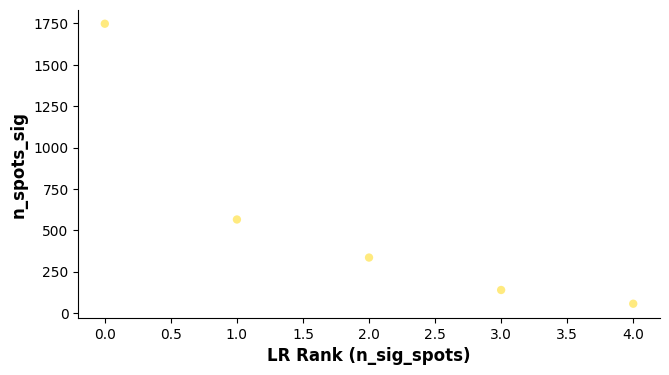

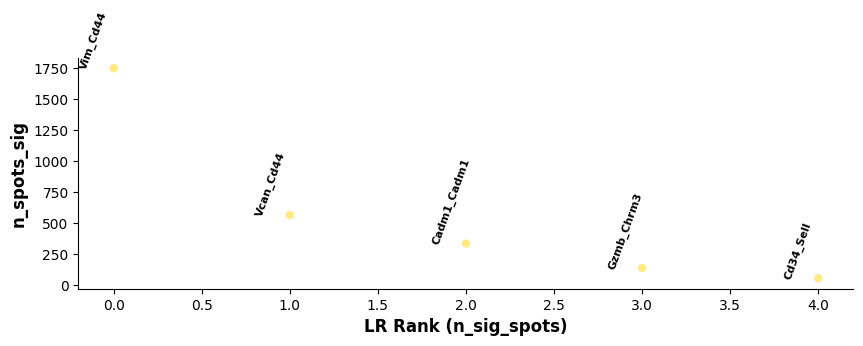

In [12]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(adata, n_top=500)
st.pl.lr_summary(adata, n_top=50, figsize=(10,3))

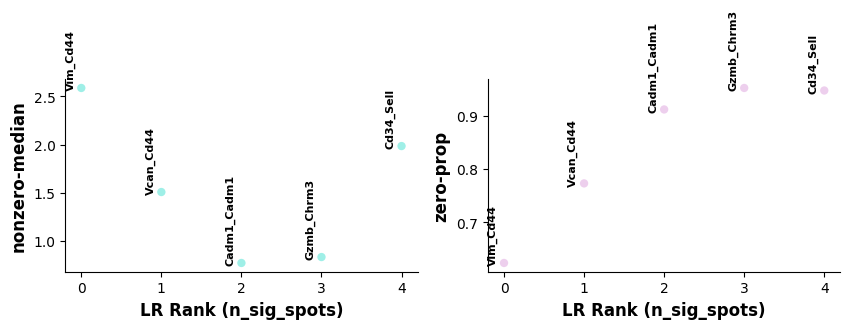

In [14]:
st.pl.lr_diagnostics(adata, figsize=(10,2.5))


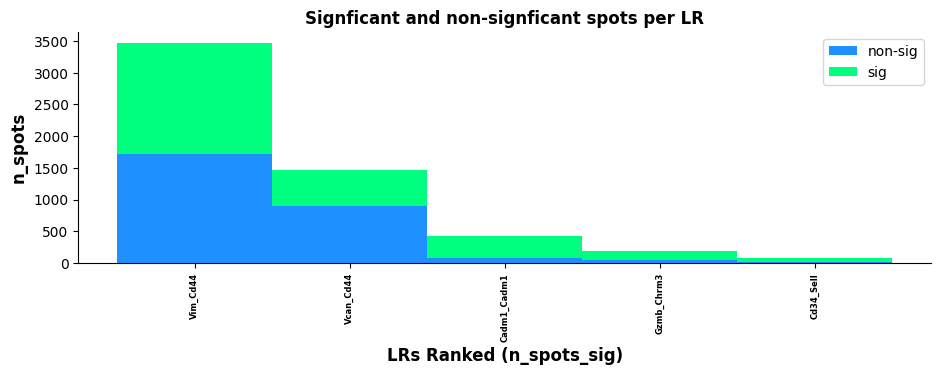

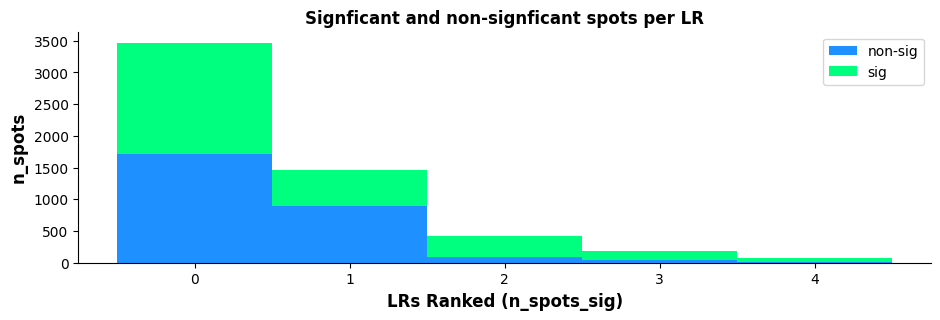

In [16]:
st.pl.lr_n_spots(adata, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(adata, n_top=500, figsize=(11, 3),
                    max_text=100)

In [18]:
best_lr = adata.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary


In [20]:
'''
stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(adata, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
'''

"\nstats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']\nfig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))\nfor i, stat in enumerate(stats):\n    st.pl.lr_result_plot(adata, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])\n    axes[i].set_title(f'{best_lr} {stat}')\n"

# Predicting significant CCIs


In [21]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(adata, 'nico_ct', # Spot cell information either in data.obs or data.uns
                  min_spots=3, # Minimum number of spots for LR to be tested.
                  spot_mixtures=True, # If True will use the label transfer scores,
                                      # so spots can have multiple cell types if score>cell_prop_cutoff
                  cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                  sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                  n_perms=100 # Permutations of cell information to get background, recommend ~1000
                 )

Falling back to discrete mode.
Getting cached neighbourhood information...
Getting information for CCI counting...


Counting celltype-celltype interactions per LR and permutating 100 times.: 100%|

Significant counts of cci_rank interactions for all LR pairs in data.uns[lr_cci_nico_ct]
Significant counts of cci_rank interactions for each LR pair stored in dictionary data.uns[per_lr_cci_nico_ct]


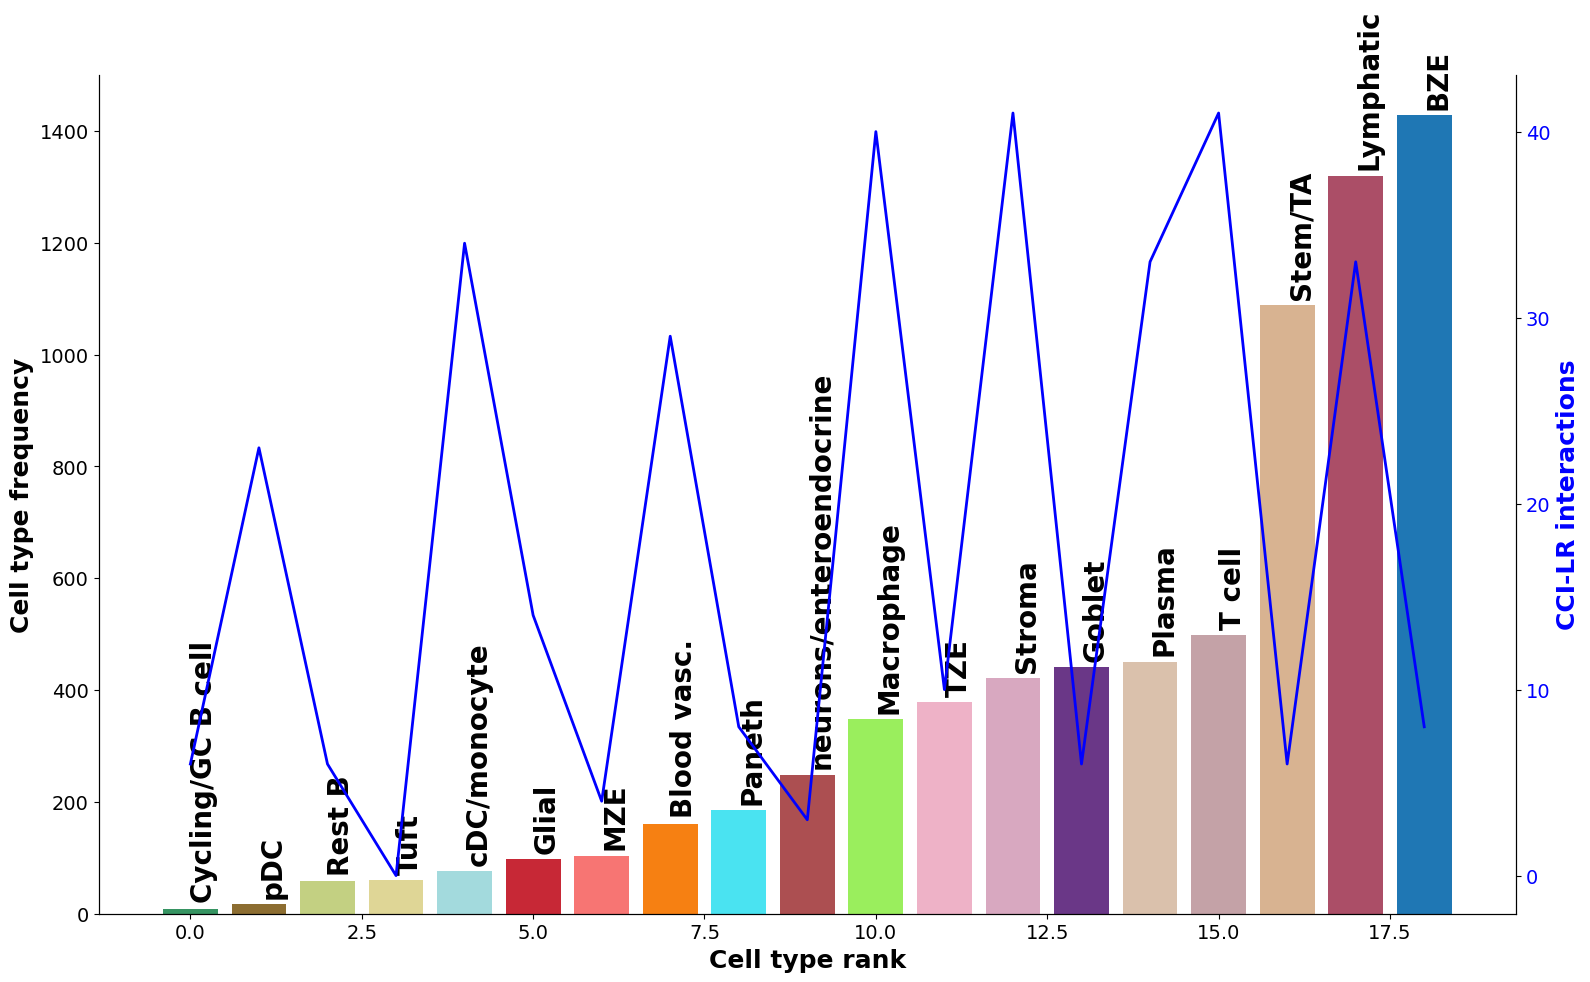

In [23]:
st.pl.cci_check(adata, 'nico_ct')

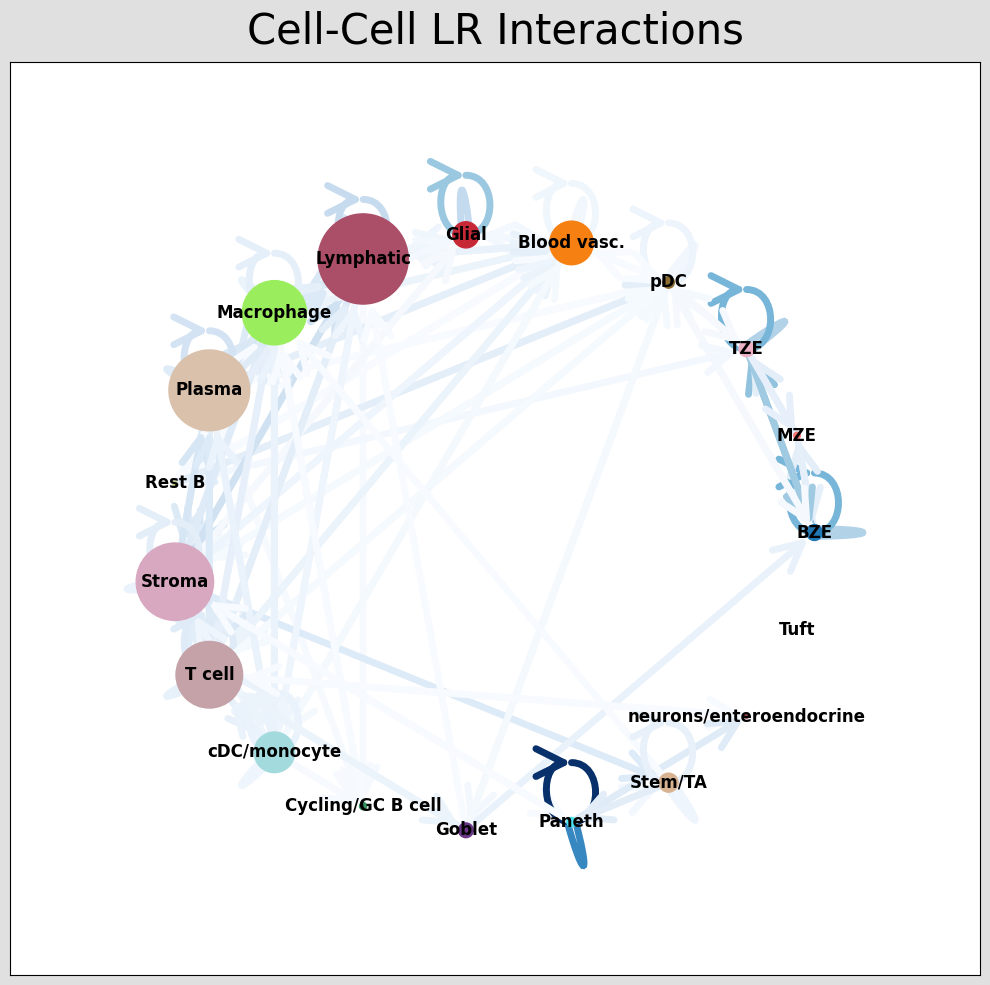

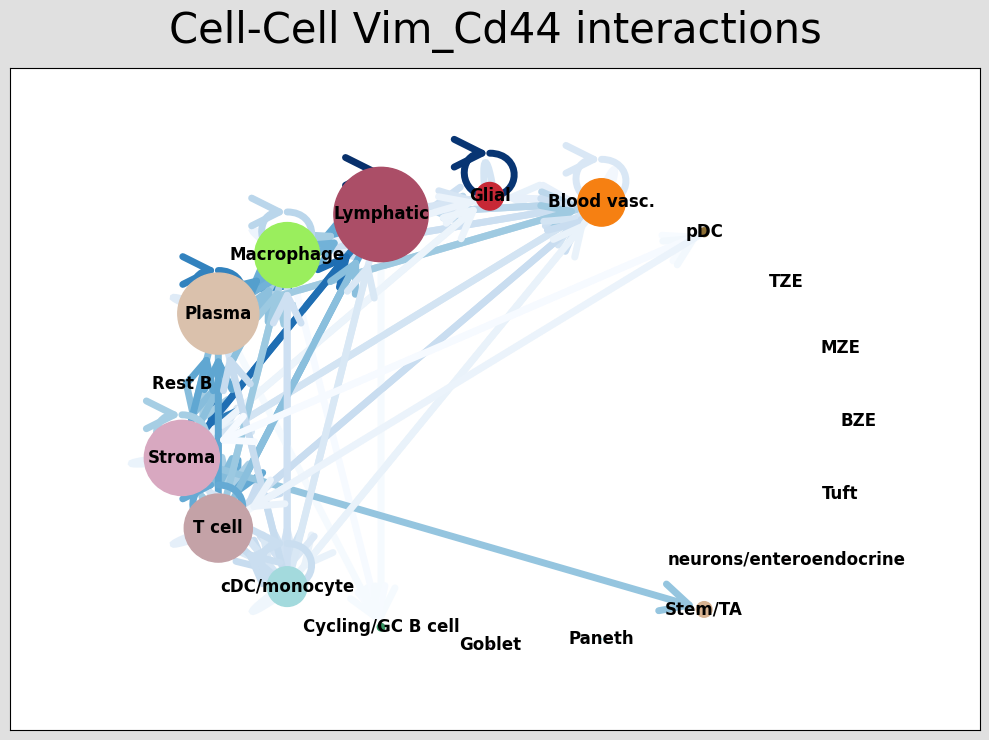

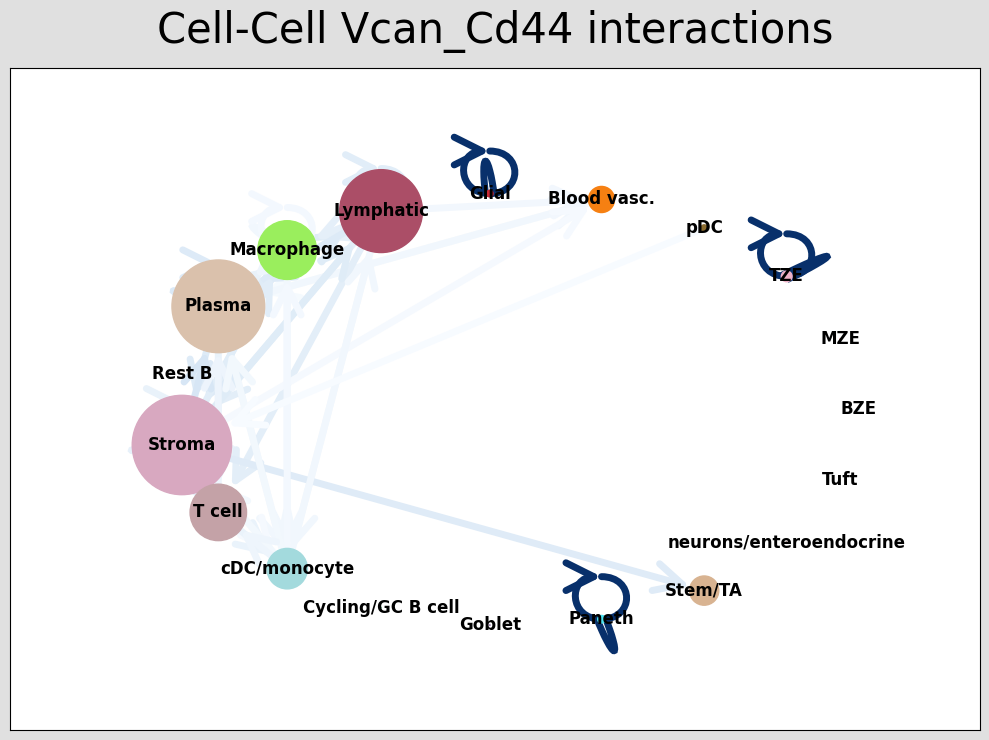

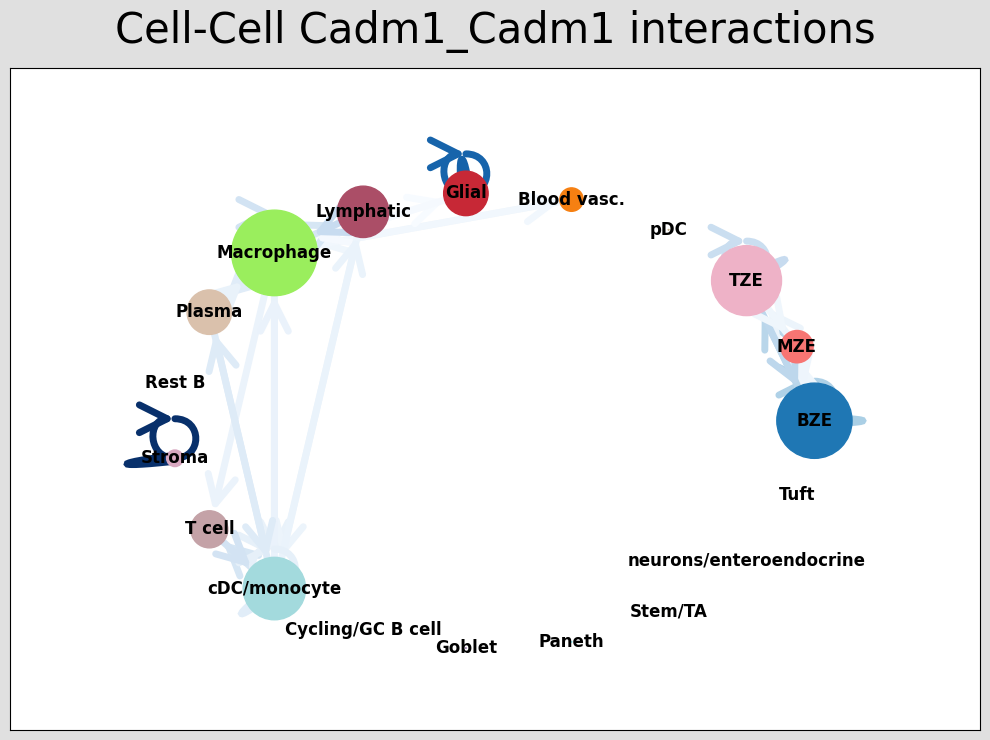

In [30]:
# Visualising the no. of interactions between cell types across all LR pairs #
pos_1 = st.pl.ccinet_plot(adata, 'nico_ct', return_pos=True)

# Just examining the cell type interactions between selected pairs #
lrs = adata.uns['lr_summary'].index.values[0:3]
for best_lr in lrs[0:3]:
    st.pl.ccinet_plot(adata, 'nico_ct', best_lr, min_counts=2,
                         figsize=(10,7.5), pos=pos_1, 
                      )

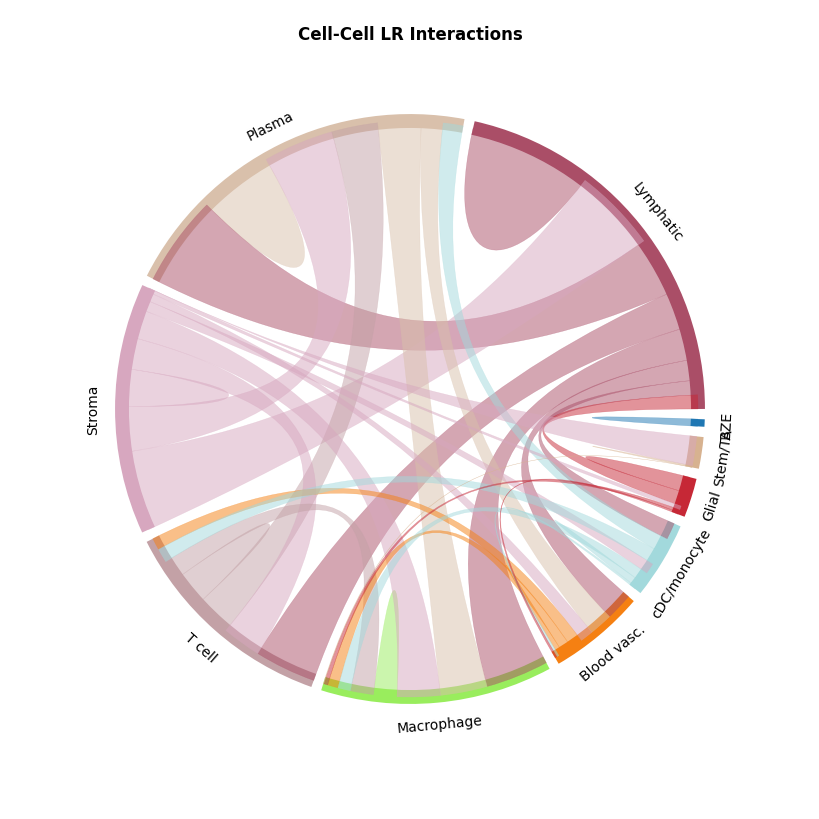

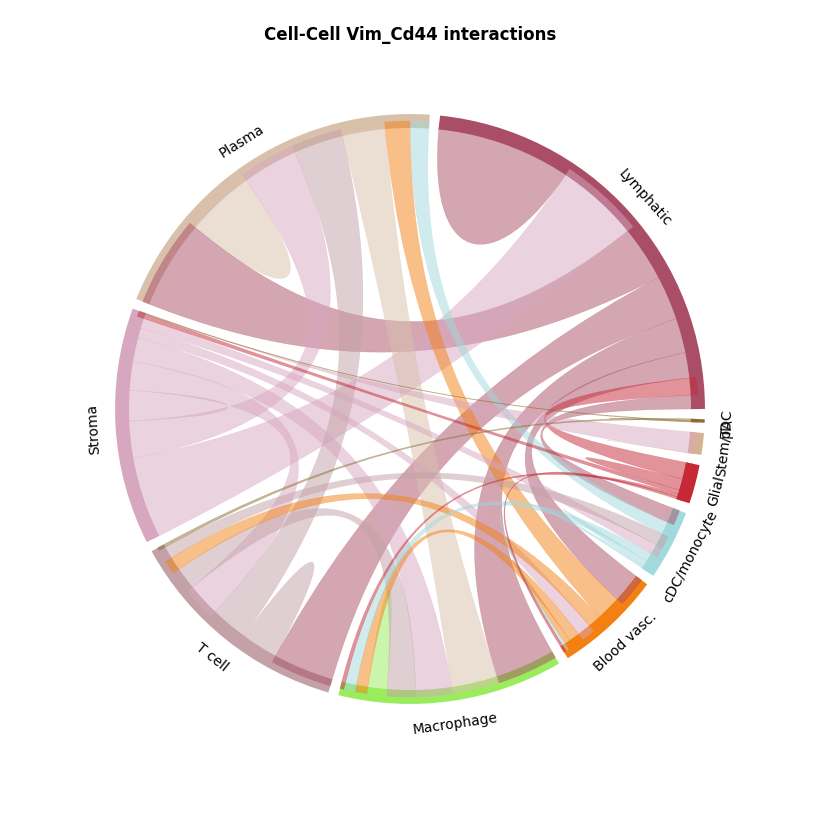

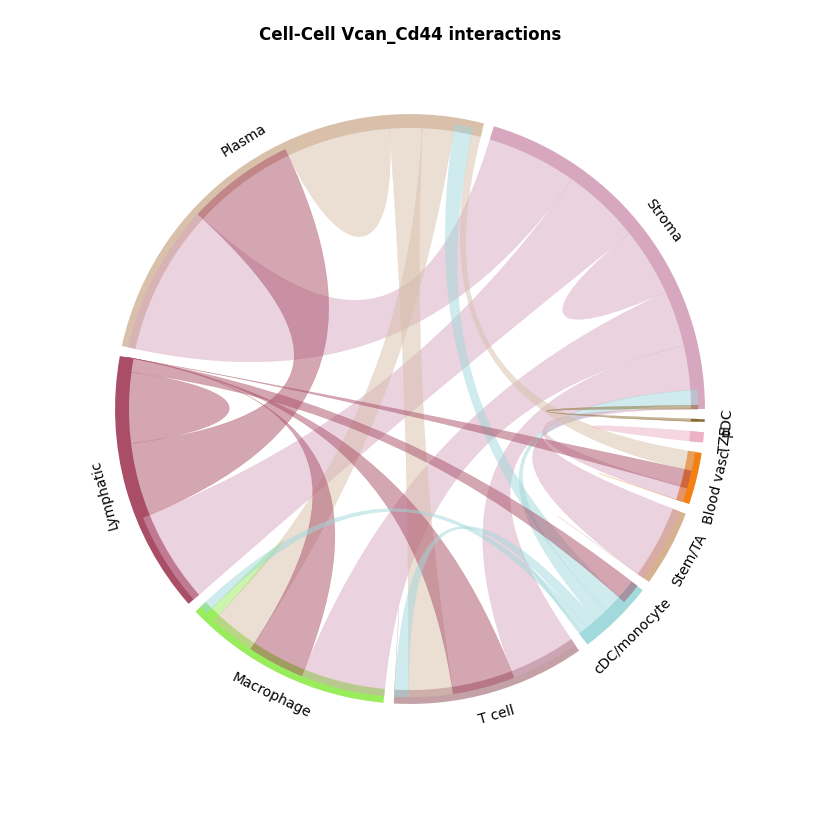

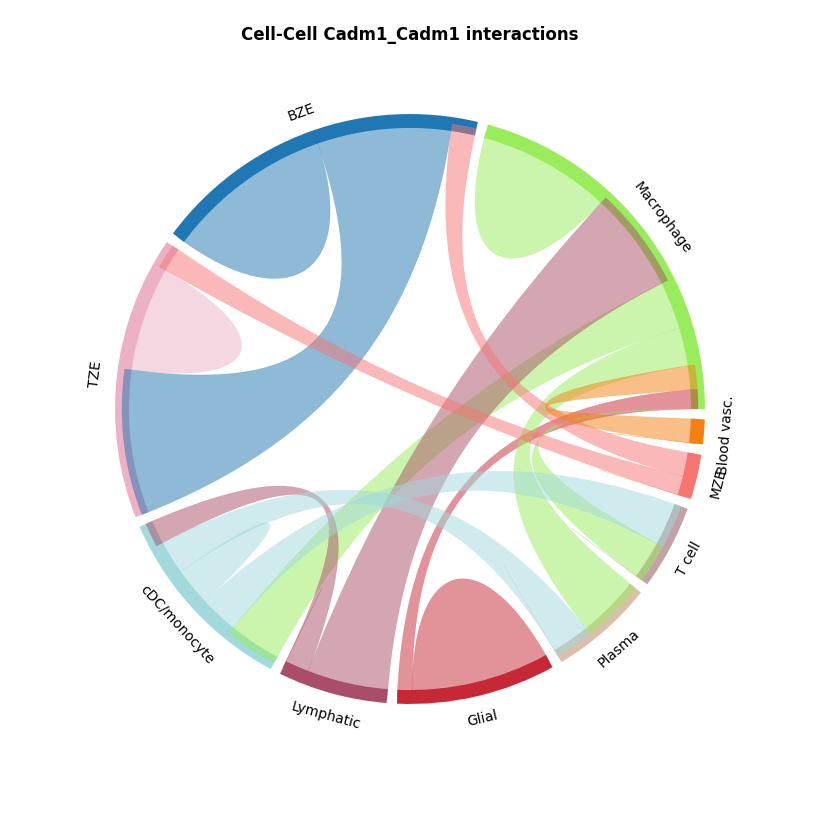

In [26]:
st.pl.lr_chord_plot(adata, 'nico_ct')

for lr in lrs:
    st.pl.lr_chord_plot(adata, 'nico_ct', lr)

<Axes: xlabel='Cell-cell interaction', ylabel='LR-pair'>

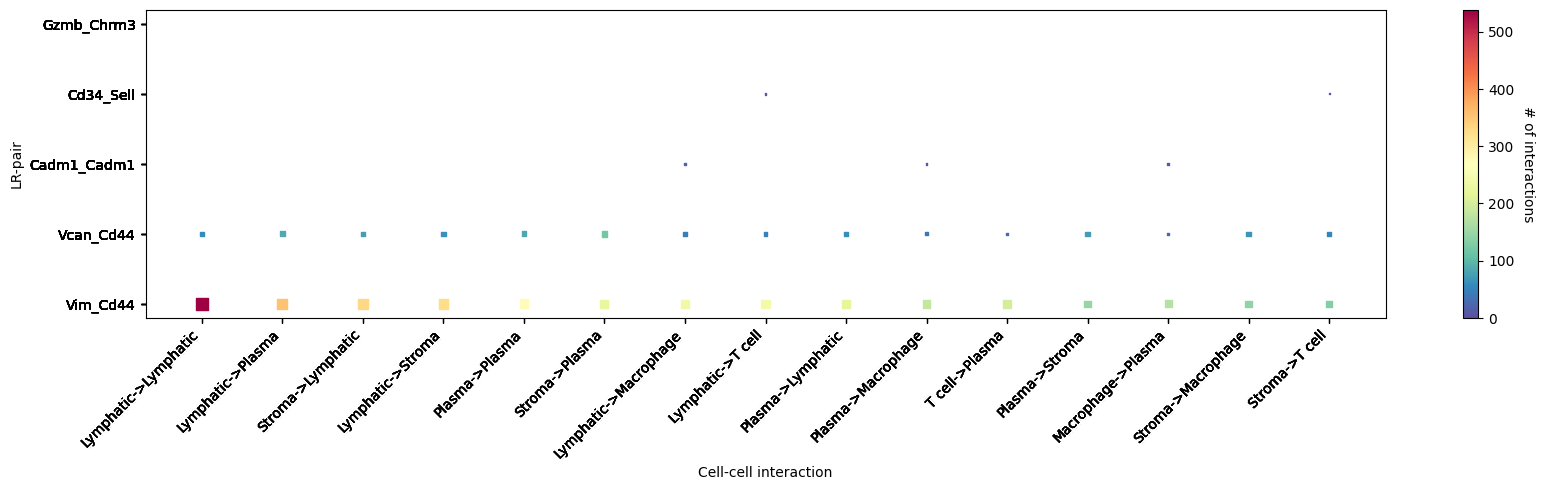

In [27]:
# This will automatically select the top interacting CCIs and their respective LRs #
st.pl.lr_cci_map(adata, 'nico_ct', lrs=None, min_total=100, figsize=(20,4))

<Axes: xlabel='Cell-cell interaction', ylabel='LR-pair'>

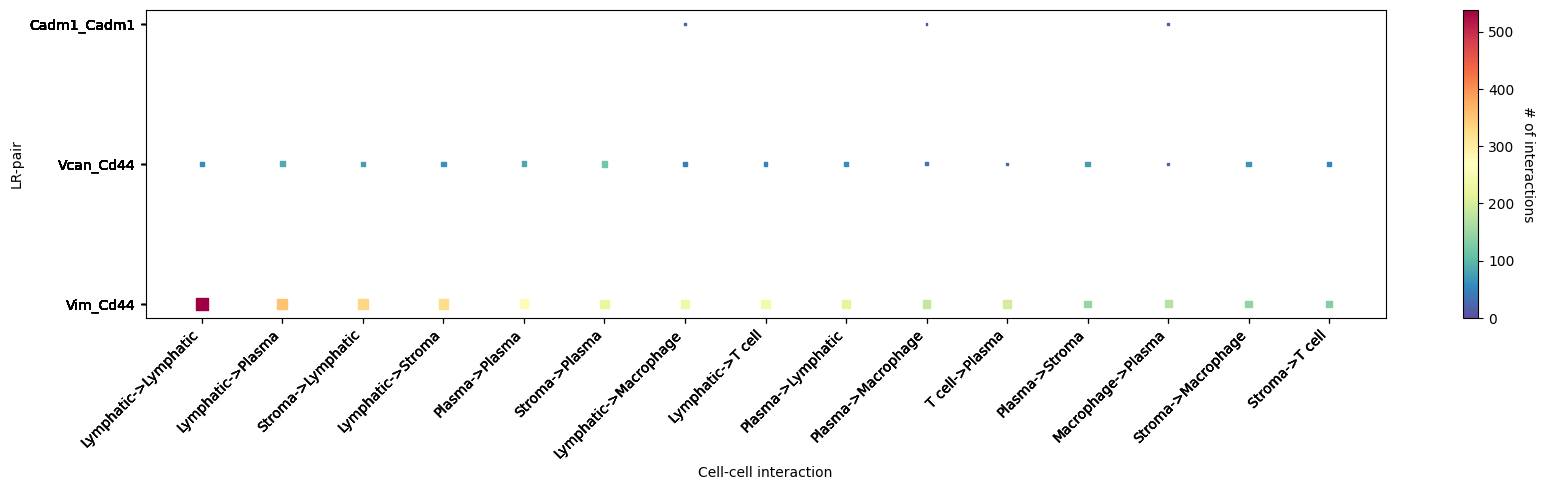

In [28]:
st.pl.lr_cci_map(adata, 'nico_ct', lrs=lrs, min_total=100, figsize=(20,4))


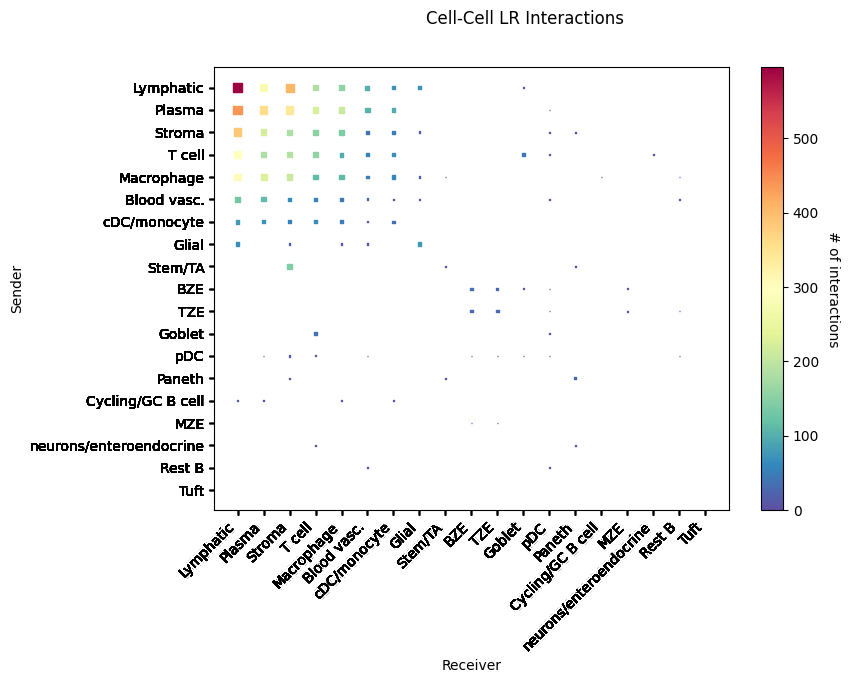

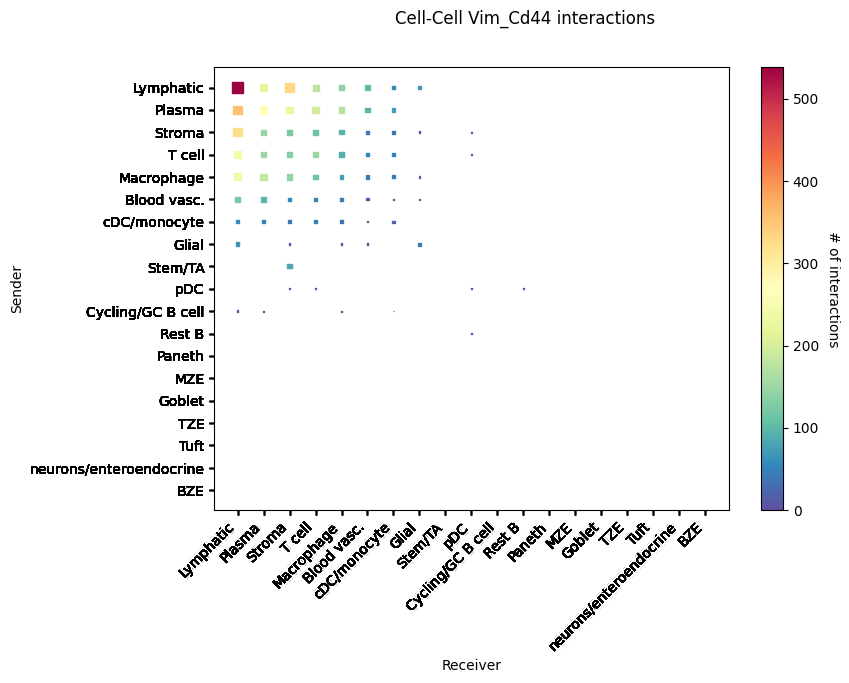

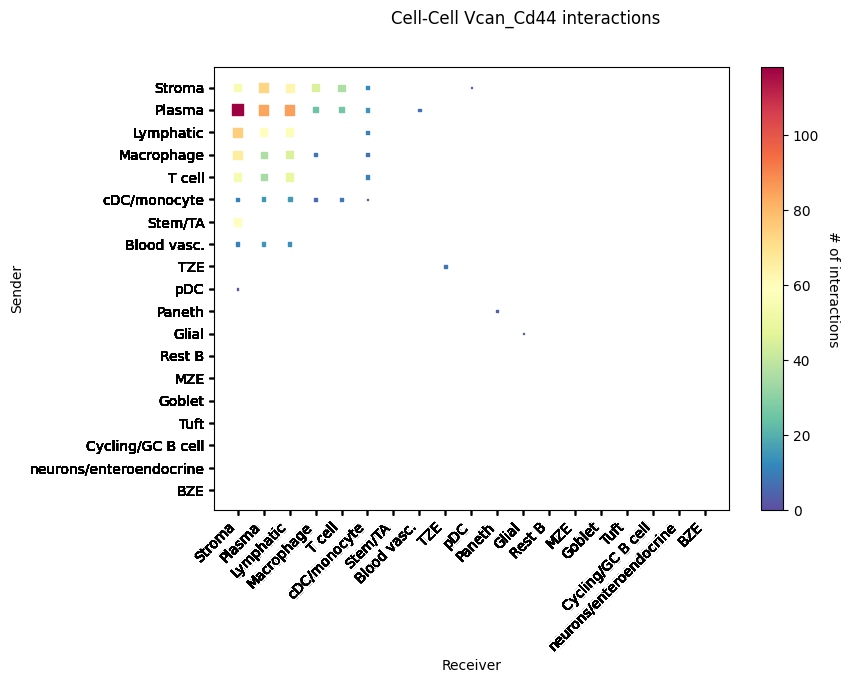

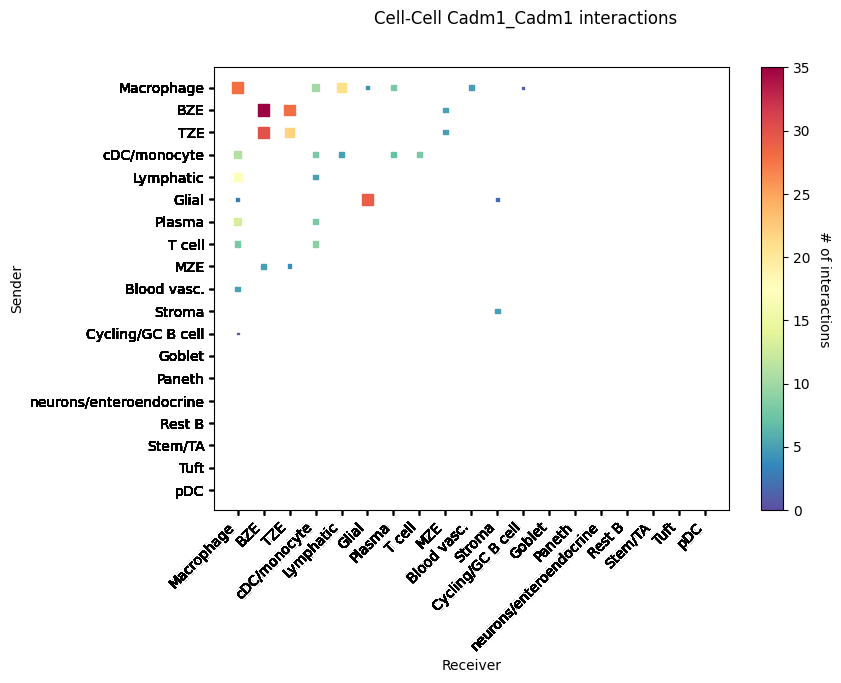

In [29]:
st.pl.cci_map(adata, 'nico_ct')

lrs = adata.uns['lr_summary'].index.values[0:3]
for lr in lrs[0:3]:
    st.pl.cci_map(adata, 'nico_ct', lr)